In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

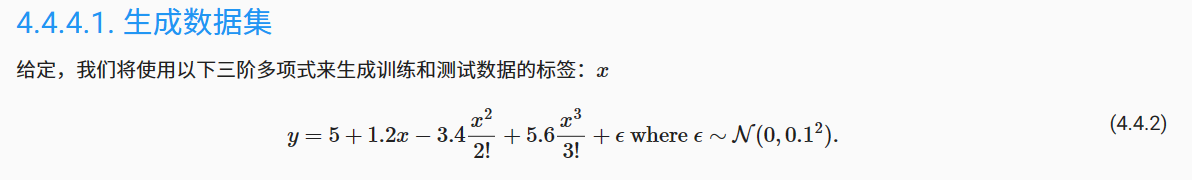

In [2]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 0.5279],
         [-0.1179]]),
 tensor([[ 1.0000e+00,  5.2790e-01,  1.3934e-01,  2.4519e-02,  3.2358e-03,
           3.4164e-04,  3.0058e-05,  2.2668e-06,  1.4958e-07,  8.7737e-09,
           4.6316e-10,  2.2228e-11,  9.7782e-13,  3.9707e-14,  1.4972e-15,
           5.2692e-17,  1.7385e-18,  5.3985e-20,  1.5833e-21,  4.3990e-23],
         [ 1.0000e+00, -1.1791e-01,  6.9511e-03, -2.7320e-04,  8.0530e-06,
          -1.8990e-07,  3.7318e-09, -6.2859e-11,  9.2644e-13, -1.2137e-14,
           1.4311e-16, -1.5339e-18,  1.5072e-20, -1.3670e-22,  1.1513e-24,
          -9.0497e-27,  6.6689e-29, -4.6254e-31,  3.0298e-33, -1.8802e-35]]),
 tensor([5.3704, 4.5490]))

In [4]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [5]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 5.0038447  1.1836921 -3.3882315  5.620267 ]]


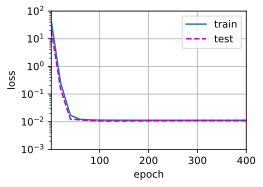

In [7]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.3370092 5.309491 ]]


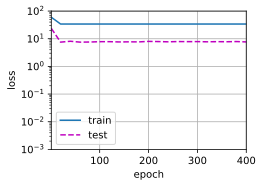

In [8]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.9985275e+00  1.2054644e+00 -3.3457947e+00  5.4932513e+00
  -2.2500008e-01  4.3490568e-01  6.3356900e-01 -2.7886423e-01
   3.8599628e-01  7.5745694e-02 -1.2297128e-01 -7.2844759e-02
   5.3801807e-03  8.6534917e-02  2.1739478e-01  1.3755914e-02
   2.1204682e-01 -3.2052692e-02 -1.7674857e-01  4.1378170e-02]]


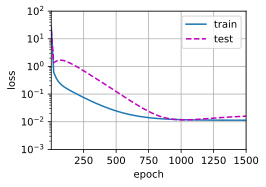

In [9]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)